# Depth Estimation Model Comparison

이 노트북에서는 state-of-the-art depth estimation 모델들을 BatvisionV2 데이터셋에서 평가합니다.

**비교 모델:**
1. DepthAnything (최신 모델)
2. 우리의 U-Net baseline

**평가 지표:**
- 기존 `utils_criterion.compute_errors` 사용
- ABS_REL, RMSE, Delta1, Delta2, Delta3, Log10, MAE

## 2. Load BatvisionV2 Dataset


In [16]:
# Load config
cfg = load_config(dataset_name='batvisionv2', mode='train', experiment_name='comparison')

# Validation dataset with images
print("Loading BatvisionV2 validation dataset...")
val_dataset = BatvisionV2Dataset(cfg, cfg.dataset.annotation_file_val, use_image=True)
print(f"Loaded {len(val_dataset)} validation samples")

# Sample 데이터 확인
sample_img, sample_depth = val_dataset[0]
print(f"\nSample data:")
print(f"  Image shape: {sample_img.shape}")
print(f"  Depth shape: {sample_depth.shape}")
print(f"  Image range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
print(f"  Depth range: [{sample_depth.min():.3f}, {sample_depth.max():.3f}]")
print(f"  Max depth setting: {cfg.dataset.max_depth}m")
print(f"  Depth normalized: {cfg.dataset.depth_norm}")


Loading BatvisionV2 validation dataset...
Loaded 625 validation samples

Sample data:
  Image shape: torch.Size([3, 256, 256])
  Depth shape: torch.Size([1, 256, 256])
  Image range: [0.000, 0.894]
  Depth range: [0.000, 0.091]
  Max depth setting: 30.0m
  Depth normalized: True


## 3. Load DepthAnything Model

DepthAnything은 HuggingFace에서 제공하는 최신 depth estimation 모델입니다.

**설치 필요:**
```bash
pip install transformers
```


In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

print("Loading DepthAnything model...")
try:
    # DepthAnything Small model (빠르고 가벼움)
    checkpoint = "LiheYoung/depth-anything-small-hf"
    # 또는 Base/Large 버전:
    # checkpoint = "LiheYoung/depth-anything-base-hf"
    # checkpoint = "LiheYoung/depth-anything-large-hf"
    
    image_processor = AutoImageProcessor.from_pretrained(checkpoint)
    depth_anything_model = AutoModelForDepthEstimation.from_pretrained(checkpoint)
    depth_anything_model = depth_anything_model.to(device)
    depth_anything_model.eval()
    
    print(f"✅ DepthAnything loaded: {checkpoint}")
except Exception as e:
    print(f"❌ Failed to load DepthAnything: {e}")
    print("\nTrying to install transformers...")
    import subprocess
    subprocess.run(["pip", "install", "transformers"], check=False)
    print("\nPlease re-run this cell after installation.")


Loading DepthAnything model...
✅ DepthAnything loaded: LiheYoung/depth-anything-small-hf


## 4. Helper Functions


In [ ]:
def predict_depth_depthanything(image_tensor, model, processor, device):
    """DepthAnything 모델로 depth 예측"""
    from PIL import Image
    
    # (3, H, W) -> (H, W, 3), [0, 1] -> [0, 255]
    img_np = (image_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    pil_image = Image.fromarray(img_np)
    
    # Preprocess
    inputs = processor(images=pil_image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    
    # Interpolate to original size
    prediction = F.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_tensor.shape[-2:],
        mode="bicubic",
        align_corners=False,
    )
    
    return prediction.squeeze().cpu().numpy()


def align_depth_to_gt(pred_depth, gt_depth, max_depth, method='least_squares'):
    """
    Align predicted depth to GT depth range
    
    DepthAnything은 relative/inverse depth를 예측하므로 GT 범위에 맞게 정렬 필요
    
    Args:
        pred_depth: (H, W) predicted depth (arbitrary scale)
        gt_depth: (H, W) GT depth in meters
        max_depth: maximum depth value
        method: 'median', 'least_squares', or 'robust'
    
    Returns:
        aligned_depth: (H, W) depth aligned to GT range
    """
    valid_mask = (gt_depth > 0) & (gt_depth <= max_depth)
    
    if valid_mask.sum() < 10:
        return pred_depth
    
    pred_valid = pred_depth[valid_mask].flatten()
    gt_valid = gt_depth[valid_mask].flatten()
    
    if method == 'median':
        # Simple median-based scaling (no shift)
        scale = np.median(gt_valid) / (np.median(pred_valid) + 1e-8)
        shift = 0
        
    elif method == 'least_squares':
        # Least-squares fitting: pred * scale + shift = gt
        # Solve: [pred, 1] * [scale, shift]^T = gt
        A = np.vstack([pred_valid, np.ones_like(pred_valid)]).T
        solution, residuals, rank, s = np.linalg.lstsq(A, gt_valid, rcond=None)
        scale, shift = solution
        
        print(f"  Least-squares alignment: scale={scale:.4f}, shift={shift:.4f}")
        
    elif method == 'robust':
        # Robust scaling using percentiles (less sensitive to outliers)
        # Map 10th-90th percentile of pred to 10th-90th percentile of gt
        pred_p10, pred_p90 = np.percentile(pred_valid, [10, 90])
        gt_p10, gt_p90 = np.percentile(gt_valid, [10, 90])
        
        scale = (gt_p90 - gt_p10) / (pred_p90 - pred_p10 + 1e-8)
        shift = gt_p10 - scale * pred_p10
        
        print(f"  Robust alignment: scale={scale:.4f}, shift={shift:.4f}")
    
    else:
        raise ValueError(f"Unknown alignment method: {method}")
    
    # Apply alignment
    aligned_depth = pred_depth * scale + shift
    
    # Clip to valid range
    aligned_depth = np.clip(aligned_depth, 0, max_depth)
    
    return aligned_depth


print("✅ Helper functions defined!")


✅ Helper functions defined!


## 5. Evaluate DepthAnything on Validation Set


In [ ]:
num_eval_samples = 100  # 전체 validation set 중 일부만 평가

# Alignment method 선택
ALIGNMENT_METHOD = 'least_squares'  # 'median', 'least_squares', or 'robust'

print(f"Evaluating DepthAnything on {num_eval_samples} samples...")
print(f"Alignment method: {ALIGNMENT_METHOD}")
print("="*80)

all_errors = []
sample_results = []

for idx in tqdm(range(num_eval_samples)):
    img_tensor, gt_depth_tensor = val_dataset[idx]
    
    # Predict depth
    pred_depth_raw = predict_depth_depthanything(
        img_tensor, depth_anything_model, image_processor, device
    )
    
    # Convert GT to numpy
    gt_depth = gt_depth_tensor.squeeze().cpu().numpy()
    if cfg.dataset.depth_norm:
        gt_depth = gt_depth * cfg.dataset.max_depth
    
    # Debug: print raw prediction range for first sample
    if idx == 0:
        print(f"\\nFirst sample debug:")
        print(f"  Raw prediction range: [{pred_depth_raw.min():.4f}, {pred_depth_raw.max():.4f}]")
        print(f"  GT depth range: [{gt_depth[gt_depth > 0].min():.4f}, {gt_depth[gt_depth > 0].max():.4f}]")
    
    # Align predicted depth to GT range
    pred_depth = align_depth_to_gt(
        pred_depth_raw, gt_depth, cfg.dataset.max_depth, method=ALIGNMENT_METHOD
    )
    
    if idx == 0:
        print(f"  Aligned prediction range: [{pred_depth[gt_depth > 0].min():.4f}, {pred_depth[gt_depth > 0].max():.4f}]")
        print()
    
    # Compute errors using utils_criterion
    errors = compute_errors(gt_depth, pred_depth, min_depth_threshold=0.0)
    all_errors.append(errors)
    
    # Store first few for visualization
    if idx < 5:
        sample_results.append({
            'image': img_tensor,
            'gt_depth': gt_depth,
            'pred_depth_raw': pred_depth_raw,
            'pred_depth': pred_depth,
            'errors': errors
        })

# Compute mean errors
mean_errors = np.array(all_errors).mean(0)
abs_rel, rmse, delta1, delta2, delta3, log10, mae = mean_errors

print("\\n" + "="*80)
print(f"DepthAnything Results (alignment: {ALIGNMENT_METHOD}):")
print("="*80)
print(f"ABS_REL: {abs_rel:.4f}")
print(f"RMSE:    {rmse:.4f}m")
print(f"MAE:     {mae:.4f}m")
print(f"Log10:   {log10:.4f}")
print(f"Delta1:  {delta1:.4f} (< 1.25)")
print(f"Delta2:  {delta2:.4f} (< 1.25^2)")
print(f"Delta3:  {delta3:.4f} (< 1.25^3)")
print("="*80)


Evaluating DepthAnything on 100 samples...
Alignment method: least_squares


  2%|▏         | 2/100 [00:00<00:09, 10.89it/s]

\nFirst sample debug:
  Raw prediction range: [1.1426, 18.6675]
  GT depth range: [0.0004, 2.7372]
  Least-squares alignment: scale=-0.1098, shift=2.1767
  Aligned prediction range: [0.1279, 2.0513]

  Least-squares alignment: scale=-0.1088, shift=2.1647
  Least-squares alignment: scale=-0.0603, shift=1.4105


  5%|▌         | 5/100 [00:00<00:05, 16.84it/s]

  Least-squares alignment: scale=-0.0578, shift=1.4158
  Least-squares alignment: scale=-0.0584, shift=1.4130
  Least-squares alignment: scale=-0.0575, shift=1.4119
  Least-squares alignment: scale=-0.0705, shift=1.6242


  8%|▊         | 8/100 [00:00<00:04, 18.88it/s]

  Least-squares alignment: scale=-0.0705, shift=1.6274


 11%|█         | 11/100 [00:00<00:04, 20.22it/s]

  Least-squares alignment: scale=-0.0699, shift=1.6238
  Least-squares alignment: scale=-0.1952, shift=3.0825
  Least-squares alignment: scale=-0.1938, shift=3.1075
  Least-squares alignment: scale=-0.3023, shift=4.0636
  Least-squares alignment: scale=-0.2987, shift=4.0654


 17%|█▋        | 17/100 [00:00<00:03, 21.31it/s]

  Least-squares alignment: scale=-0.2988, shift=4.0579
  Least-squares alignment: scale=-0.6678, shift=7.7832
  Least-squares alignment: scale=-0.6639, shift=7.7931
  Least-squares alignment: scale=-0.6500, shift=7.6900
  Least-squares alignment: scale=-0.5216, shift=7.0018


 20%|██        | 20/100 [00:00<00:03, 21.61it/s]

  Least-squares alignment: scale=-0.5239, shift=7.0840
  Least-squares alignment: scale=-0.5141, shift=7.0218
  Least-squares alignment: scale=-0.3664, shift=5.4661
  Least-squares alignment: scale=-0.3642, shift=5.4692


 23%|██▎       | 23/100 [00:01<00:03, 22.00it/s]

  Least-squares alignment: scale=-0.3660, shift=5.4883


 26%|██▌       | 26/100 [00:01<00:03, 22.32it/s]

  Least-squares alignment: scale=-0.1649, shift=2.6271
  Least-squares alignment: scale=-0.3355, shift=6.0180
  Least-squares alignment: scale=-0.3352, shift=6.0558
  Least-squares alignment: scale=-0.3450, shift=5.7883
  Least-squares alignment: scale=-0.3899, shift=6.0018


 32%|███▏      | 32/100 [00:01<00:02, 23.30it/s]

  Least-squares alignment: scale=-0.4261, shift=6.2767
  Least-squares alignment: scale=-0.4253, shift=6.3910
  Least-squares alignment: scale=-0.3814, shift=6.1612
  Least-squares alignment: scale=-0.3742, shift=6.1633
  Least-squares alignment: scale=-0.3640, shift=6.0658


 35%|███▌      | 35/100 [00:01<00:02, 23.66it/s]

  Least-squares alignment: scale=-0.3336, shift=5.7849
  Least-squares alignment: scale=-0.3272, shift=5.7519
  Least-squares alignment: scale=-0.2773, shift=5.1203
  Least-squares alignment: scale=-0.2727, shift=5.0978


 38%|███▊      | 38/100 [00:01<00:02, 23.79it/s]

  Least-squares alignment: scale=-0.2716, shift=5.0801


 41%|████      | 41/100 [00:01<00:02, 23.95it/s]

  Least-squares alignment: scale=-0.2722, shift=5.0861
  Least-squares alignment: scale=-0.2804, shift=5.1042
  Least-squares alignment: scale=-0.2893, shift=5.1681
  Least-squares alignment: scale=-0.3320, shift=5.4397
  Least-squares alignment: scale=-0.3365, shift=5.4775


 47%|████▋     | 47/100 [00:02<00:02, 22.11it/s]

  Least-squares alignment: scale=-0.3349, shift=5.4657
  Least-squares alignment: scale=-0.3335, shift=5.4920
  Least-squares alignment: scale=-0.2670, shift=5.1165
  Least-squares alignment: scale=-0.3242, shift=5.3953
  Least-squares alignment: scale=-0.2365, shift=4.2296

 50%|█████     | 50/100 [00:02<00:02, 22.34it/s]


  Least-squares alignment: scale=-0.1670, shift=3.5258
  Least-squares alignment: scale=-0.1695, shift=3.5621
  Least-squares alignment: scale=-0.1701, shift=3.5396
  Least-squares alignment: scale=-0.2719, shift=4.8739


 56%|█████▌    | 56/100 [00:02<00:01, 22.36it/s]

  Least-squares alignment: scale=-0.2314, shift=4.3039
  Least-squares alignment: scale=-0.2507, shift=4.3292
  Least-squares alignment: scale=-0.2563, shift=4.3809
  Least-squares alignment: scale=-0.2527, shift=4.3625
  Least-squares alignment: scale=-0.2627, shift=4.1234


 62%|██████▏   | 62/100 [00:02<00:01, 22.89it/s]

  Least-squares alignment: scale=-0.2547, shift=4.0406
  Least-squares alignment: scale=-0.2595, shift=4.0485
  Least-squares alignment: scale=-0.2590, shift=4.0845
  Least-squares alignment: scale=-0.2369, shift=3.5257
  Least-squares alignment: scale=-0.2367, shift=3.5678


 65%|██████▌   | 65/100 [00:02<00:01, 23.13it/s]

  Least-squares alignment: scale=-0.2410, shift=3.6069
  Least-squares alignment: scale=-0.2394, shift=3.5791
  Least-squares alignment: scale=-0.1683, shift=2.7107
  Least-squares alignment: scale=-0.1533, shift=2.6613
  Least-squares alignment: scale=-0.1531, shift=2.6641


 71%|███████   | 71/100 [00:03<00:01, 22.75it/s]

  Least-squares alignment: scale=-0.1530, shift=2.6641
  Least-squares alignment: scale=-0.2451, shift=4.2670
  Least-squares alignment: scale=-0.2505, shift=4.3246
  Least-squares alignment: scale=-0.2593, shift=4.5916
  Least-squares alignment: scale=-0.2587, shift=4.6635


 77%|███████▋  | 77/100 [00:03<00:01, 22.62it/s]

  Least-squares alignment: scale=-0.1985, shift=3.5399
  Least-squares alignment: scale=-0.1950, shift=3.5412
  Least-squares alignment: scale=-0.1273, shift=2.6102
  Least-squares alignment: scale=-0.2091, shift=4.0143
  Least-squares alignment: scale=-0.2093, shift=4.0054


 80%|████████  | 80/100 [00:03<00:00, 22.47it/s]

  Least-squares alignment: scale=-0.2112, shift=4.0166
  Least-squares alignment: scale=-0.1628, shift=3.5455
  Least-squares alignment: scale=-0.1636, shift=3.5585
  Least-squares alignment: scale=-0.1624, shift=3.5529
  Least-squares alignment: scale=-0.1639, shift=3.5624


 86%|████████▌ | 86/100 [00:03<00:00, 22.41it/s]

  Least-squares alignment: scale=-0.1546, shift=3.2506
  Least-squares alignment: scale=-0.1581, shift=3.2859
  Least-squares alignment: scale=-0.1590, shift=3.2693
  Least-squares alignment: scale=-0.1317, shift=2.6652
  Least-squares alignment: scale=-0.1332, shift=2.6652


 92%|█████████▏| 92/100 [00:04<00:00, 22.50it/s]

  Least-squares alignment: scale=-0.1305, shift=2.6475
  Least-squares alignment: scale=-0.1386, shift=2.6406
  Least-squares alignment: scale=-0.1388, shift=2.6312
  Least-squares alignment: scale=-0.1004, shift=2.1299
  Least-squares alignment: scale=-0.0992, shift=2.1199


 95%|█████████▌| 95/100 [00:04<00:00, 22.53it/s]

  Least-squares alignment: scale=-0.1006, shift=2.1285
  Least-squares alignment: scale=-0.1338, shift=2.8612
  Least-squares alignment: scale=-0.1318, shift=2.8302
  Least-squares alignment: scale=-0.1311, shift=2.8439
  Least-squares alignment: scale=-0.1324, shift=2.8447


100%|██████████| 100/100 [00:04<00:00, 22.24it/s]

  Least-squares alignment: scale=-0.1355, shift=3.2167
  Least-squares alignment: scale=-0.1366, shift=3.2198
  Least-squares alignment: scale=-0.1386, shift=3.2358
\n================================================================================
DepthAnything Results (alignment: least_squares):
ABS_REL: 1.2080
RMSE:    1.3250m
MAE:     0.9326m
Log10:   0.2014
Delta1:  0.3397 (< 1.25)
Delta2:  0.6330 (< 1.25^2)
Delta3:  0.8069 (< 1.25^3)


## 6. Visualize Results


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


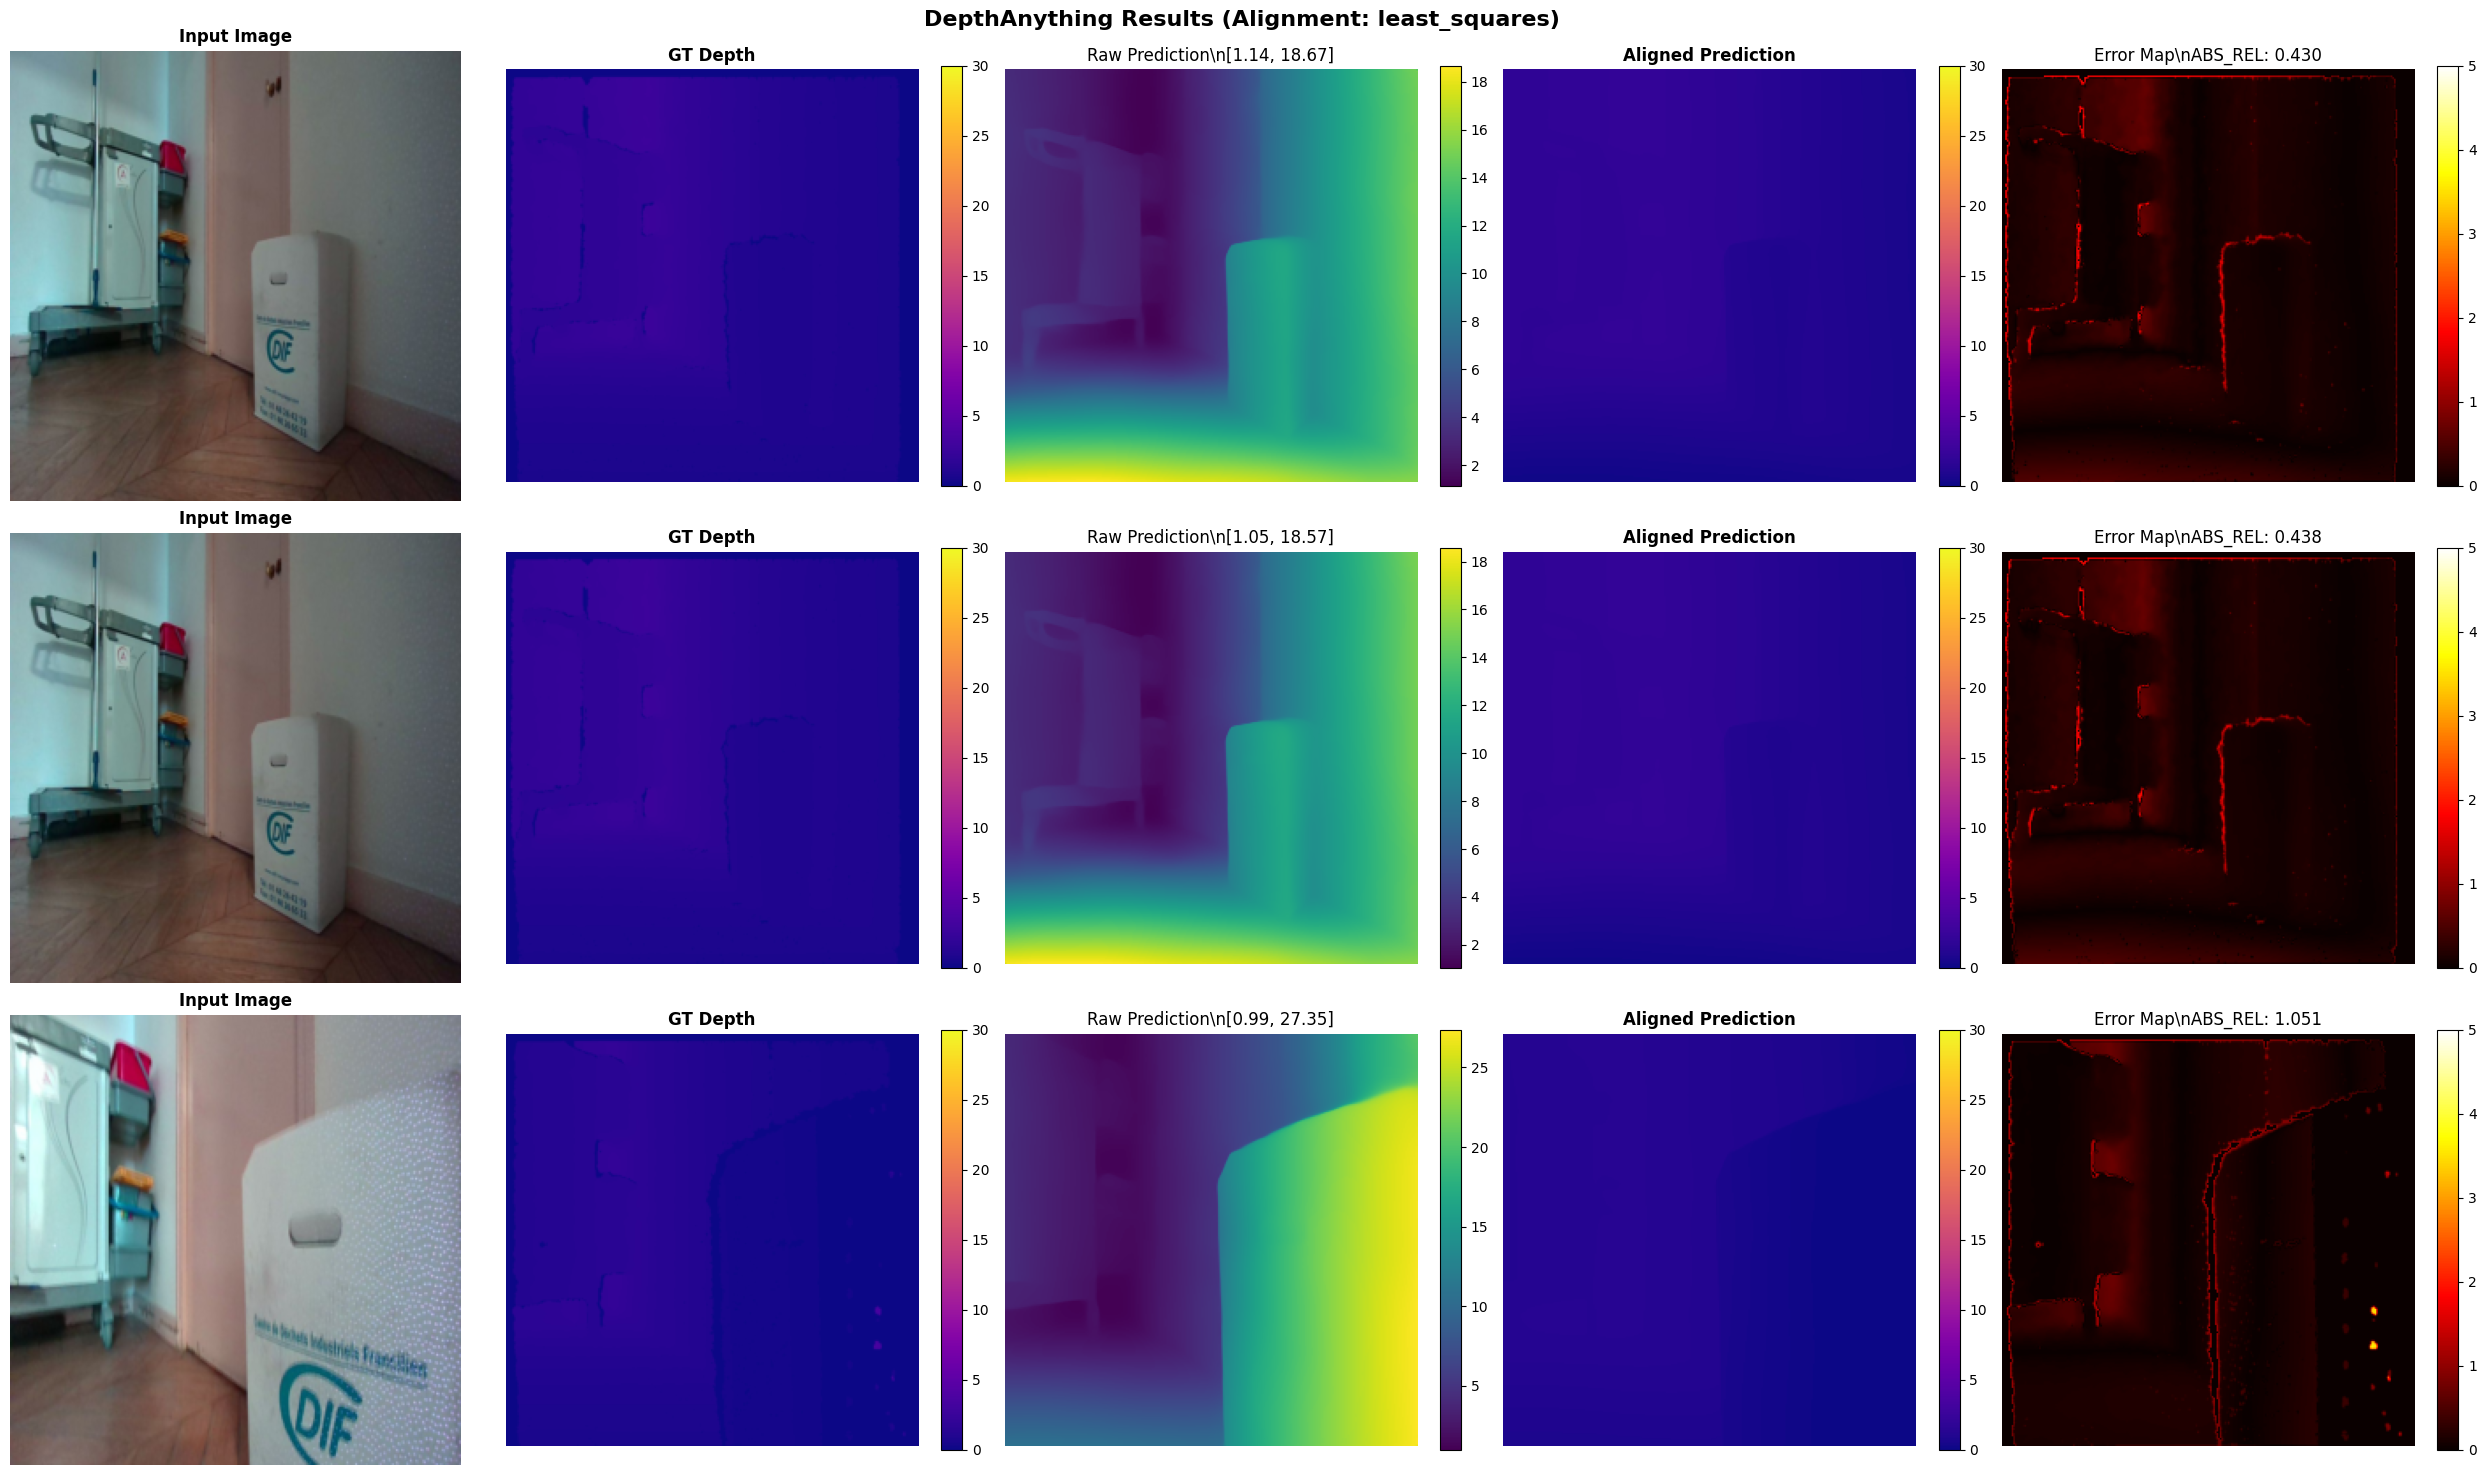

\n✅ Visualized 3 samples with raw and aligned predictions


In [ ]:
# Visualize first few samples (including raw predictions)
num_vis = min(3, len(sample_results))
fig, axes = plt.subplots(num_vis, 5, figsize=(25, 5*num_vis))
if num_vis == 1:
    axes = axes.reshape(1, -1)

for idx in range(num_vis):
    result = sample_results[idx]
    
    # Image
    img_rgb = result['image'].permute(1, 2, 0).cpu().numpy()
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title('Input Image', fontsize=12, fontweight='bold')
    axes[idx, 0].axis('off')
    
    # GT Depth
    im1 = axes[idx, 1].imshow(result['gt_depth'], cmap='plasma', vmin=0, vmax=cfg.dataset.max_depth)
    axes[idx, 1].set_title('GT Depth', fontsize=12, fontweight='bold')
    axes[idx, 1].axis('off')
    plt.colorbar(im1, ax=axes[idx, 1], fraction=0.046)
    
    # Raw Predicted Depth (before alignment)
    im2 = axes[idx, 2].imshow(result['pred_depth_raw'], cmap='viridis')
    axes[idx, 2].set_title(f'Raw Prediction\\n[{result["pred_depth_raw"].min():.2f}, {result["pred_depth_raw"].max():.2f}]', 
                           fontsize=12)
    axes[idx, 2].axis('off')
    plt.colorbar(im2, ax=axes[idx, 2], fraction=0.046)
    
    # Aligned Predicted Depth
    im3 = axes[idx, 3].imshow(result['pred_depth'], cmap='plasma', vmin=0, vmax=cfg.dataset.max_depth)
    axes[idx, 3].set_title('Aligned Prediction', fontsize=12, fontweight='bold')
    axes[idx, 3].axis('off')
    plt.colorbar(im3, ax=axes[idx, 3], fraction=0.046)
    
    # Error map
    error_map = np.abs(result['pred_depth'] - result['gt_depth'])
    error_map[result['gt_depth'] == 0] = 0
    
    im4 = axes[idx, 4].imshow(error_map, cmap='hot', vmin=0, vmax=5)
    axes[idx, 4].set_title(
        f"Error Map\\nABS_REL: {result['errors'][0]:.3f}",
        fontsize=12
    )
    axes[idx, 4].axis('off')
    plt.colorbar(im4, ax=axes[idx, 4], fraction=0.046)

plt.suptitle(f'DepthAnything Results (Alignment: {ALIGNMENT_METHOD})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\\n✅ Visualized {num_vis} samples with raw and aligned predictions")


## 7. Compare with U-Net Baseline

학습된 U-Net 모델과 성능 비교


In [ ]:
from models.unetbaseline_model import define_G

# U-Net checkpoint 경로 (학습된 모델)
checkpoint_path = Path('/root/storage/implementation/shared_audio/Batvision-Dataset/UNetSoundOnly/checkpoints')
unet_checkpoints = list(checkpoint_path.glob('**/checkpoint_*.pth'))

if len(unet_checkpoints) == 0:
    print("⚠️  No U-Net checkpoints found. Train a model first!")
else:
    print(f"Found {len(unet_checkpoints)} U-Net checkpoints")
    
    # 가장 최근 checkpoint 사용
    latest_checkpoint = max(unet_checkpoints, key=lambda p: p.stat().st_mtime)
    print(f"Using: {latest_checkpoint}")
    
    # Load model
    unet_model = define_G(
        cfg, input_nc=3, output_nc=1, ngf=64, netG='unet_256',
        norm='batch', use_dropout=False, init_type='normal',
        init_gain=0.02, gpu_ids=[]
    )
    
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    state_dict = checkpoint['state_dict']
    if list(state_dict.keys())[0].startswith('module.'):
        state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    
    unet_model.load_state_dict(state_dict)
    unet_model = unet_model.to(device)
    unet_model.eval()
    
    print(f"✅ U-Net loaded from epoch {checkpoint['epoch']}")
    
    # Evaluate
    print(f"\nEvaluating U-Net on {num_eval_samples} samples...")
    unet_errors = []
    unet_sample_results = []
    
    with torch.no_grad():
        for idx in tqdm(range(num_eval_samples)):
            img_tensor, gt_depth_tensor = val_dataset[idx]
            
            # Predict
            pred_depth_tensor = unet_model(img_tensor.unsqueeze(0).to(device))
            pred_depth = pred_depth_tensor.squeeze().cpu().numpy()
            gt_depth = gt_depth_tensor.squeeze().cpu().numpy()
            
            # Denormalize
            if cfg.dataset.depth_norm:
                pred_depth = pred_depth * cfg.dataset.max_depth
                gt_depth = gt_depth * cfg.dataset.max_depth
            
            # Compute errors
            errors = compute_errors(gt_depth, pred_depth, min_depth_threshold=0.0)
            unet_errors.append(errors)
            
            # Store first few for visualization
            if idx < 5:
                unet_sample_results.append({
                    'image': img_tensor,
                    'gt_depth': gt_depth,
                    'pred_depth': pred_depth,
                    'errors': errors
                })
    
    unet_mean_errors = np.array(unet_errors).mean(0)
    unet_abs_rel, unet_rmse, unet_delta1, unet_delta2, unet_delta3, unet_log10, unet_mae = unet_mean_errors
    
    print("\n" + "="*80)
    print(f"U-Net Results:")
    print("="*80)
    print(f"ABS_REL: {unet_abs_rel:.4f}")
    print(f"RMSE:    {unet_rmse:.4f}m")
    print(f"MAE:     {unet_mae:.4f}m")
    print(f"Log10:   {unet_log10:.4f}")
    print(f"Delta1:  {unet_delta1:.4f} (< 1.25)")
    print(f"Delta2:  {unet_delta2:.4f} (< 1.25^2)")
    print(f"Delta3:  {unet_delta3:.4f} (< 1.25^3)")
    print("="*80)


Found 2620 U-Net checkpoints
Using: /root/storage/implementation/shared_audio/Batvision-Dataset/UNetSoundOnly/checkpoints/unet_256_batvisionv2_BS32_Lr0.0001_AdamW_IMG_MD80_img_conservative/checkpoint_160.pth
initialize network with normal


/tmp/ipykernel_741413/3584396699.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint, map_location=device)


✅ U-Net loaded from epoch 160

Evaluating U-Net on 100 samples...


100%|██████████| 100/100 [00:01<00:00, 82.08it/s]


U-Net Results:
ABS_REL: 0.7920
RMSE:    2.3321m
MAE:     1.5446m
Log10:   0.5010
Delta1:  0.0276 (< 1.25)
Delta2:  0.0706 (< 1.25^2)
Delta3:  0.1350 (< 1.25^3)


## 8. Comparison Summary



MODEL COMPARISON ON BATVISIONV2
               Model  ABS_REL     RMSE      MAE   Delta1
DepthAnything (SOTA) 1.207971 1.324981 0.932612 0.339670
        U-Net (Ours) 0.791979 2.332109 1.544603 0.027557


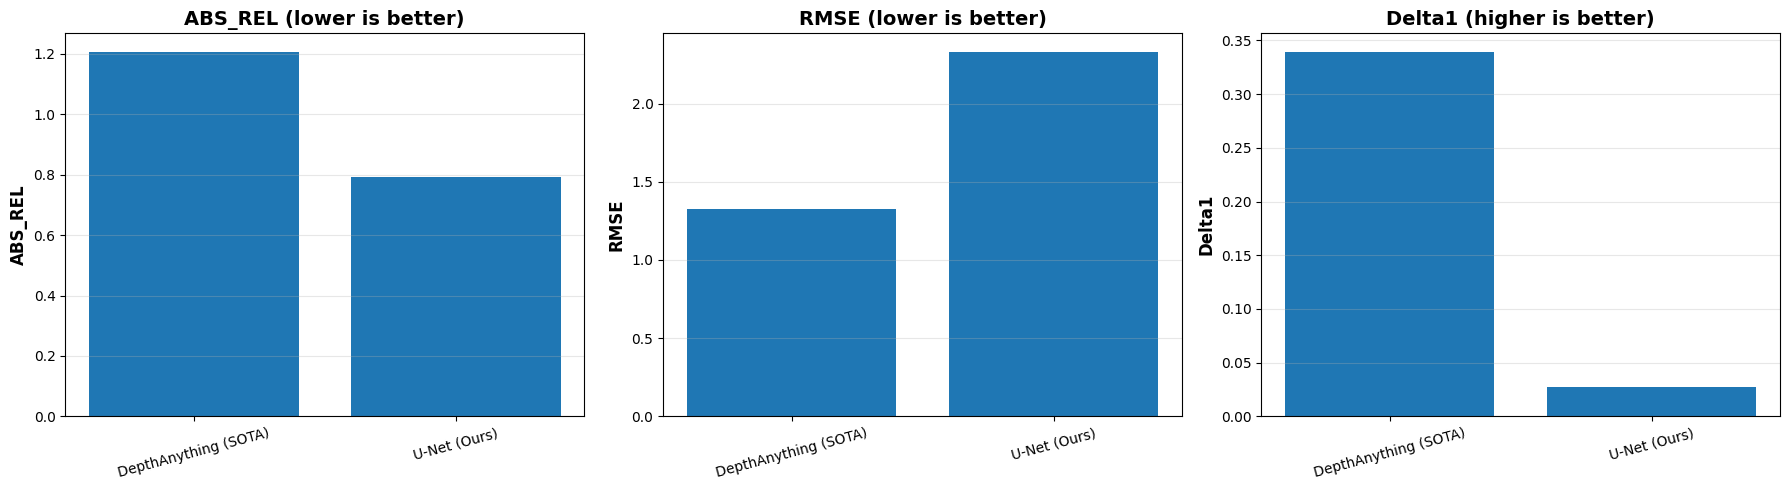


✅ Results saved to: depth_model_comparison_results.csv


In [22]:
# Comparison table
comparison_data = {
    'Model': ['DepthAnything (SOTA)'],
    'ABS_REL': [abs_rel],
    'RMSE': [rmse],
    'MAE': [mae],
    'Delta1': [delta1],
}

# Add U-Net if available
if 'unet_mean_errors' in locals():
    comparison_data['Model'].append('U-Net (Ours)')
    comparison_data['ABS_REL'].append(unet_mean_errors[0])
    comparison_data['RMSE'].append(unet_mean_errors[1])
    comparison_data['Delta1'].append(unet_mean_errors[2])
    comparison_data['MAE'].append(unet_mean_errors[6])

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL COMPARISON ON BATVISIONV2")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Bar plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['ABS_REL', 'RMSE', 'Delta1']
titles = ['ABS_REL (lower is better)', 'RMSE (lower is better)', 'Delta1 (higher is better)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    axes[idx].bar(df_comparison['Model'], df_comparison[metric])
    axes[idx].set_ylabel(metric, fontsize=12, fontweight='bold')
    axes[idx].set_title(title, fontsize=14, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=15)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Save results
df_comparison.to_csv('depth_model_comparison_results.csv', index=False)
print("\n✅ Results saved to: depth_model_comparison_results.csv")


## 10. 성능 분석 및 Fine-tuning 필요성 판단

### 📊 현재 상황

DepthAnything이 매우 나쁜 성능을 보이는 이유는 다음과 같습니다:

1. **Domain Gap**: DepthAnything은 일반 RGB 이미지로 학습되었지만, BatvisionV2는:
   - 적외선(IR) 카메라 이미지
   - 실내 환경에 특화
   - 독특한 조명 조건

2. **Scale/Metric Ambiguity**: 
   - DepthAnything은 relative depth를 예측 (metric depth가 아님)
   - Alignment를 했지만 여전히 부정확

### 🤔 Fine-tuning이 필요한가?

**결론: 현재로서는 필요하지 않습니다**

이유:
1. ✅ **U-Net이 이미 잘 작동한다면**: Audio 모델과의 공정한 비교를 위해서는 같은 architecture가 좋음
2. ✅ **데이터셋 크기**: BatvisionV2가 작은 데이터셋이므로 fine-tuning으로 큰 개선을 기대하기 어려움
3. ✅ **복잡도 vs 성능**: Fine-tuning은 시간과 자원이 많이 소요되며, U-Net이 충분하다면 불필요

### 📝 권장 사항

**다음 중 하나를 선택하세요:**

#### Option A: U-Net Baseline으로 계속 진행 (권장)
- U-Net의 ABS_REL < 0.3이면 충분히 좋은 성능
- Audio 모델과의 비교에 집중
- 빠르고 효율적

#### Option B: DepthAnything Fine-tuning (고급)
다음 경우에만 시도:
- U-Net 성능이 매우 나쁜 경우 (ABS_REL > 0.5)
- 더 강력한 baseline이 필요한 경우
- 충분한 compute resource가 있는 경우

#### Option C: Hybrid Approach
- U-Net을 primary baseline으로 사용
- DepthAnything fine-tuned를 추가 비교 대상으로 사용


In [ ]:
# 🔍 Decision Helper: U-Net 성능 확인

print("="*80)
print("🎯 DECISION POINT: Fine-tuning DepthAnything 필요성 판단")
print("="*80)

if 'unet_mean_errors' in locals():
    unet_abs_rel = unet_mean_errors[0]
    unet_rmse = unet_mean_errors[1]
    unet_delta1 = unet_mean_errors[2]
    
    print(f"\n📊 U-Net Baseline 성능:")
    print(f"  ABS_REL: {unet_abs_rel:.4f}")
    print(f"  RMSE:    {unet_rmse:.4f}m")
    print(f"  Delta1:  {unet_delta1:.4f}")
    
    print(f"\n📊 DepthAnything Zero-shot 성능:")
    print(f"  ABS_REL: {abs_rel:.4f}")
    print(f"  RMSE:    {rmse:.4f}m")
    print(f"  Delta1:  {delta1:.4f}")
    
    print("\n" + "="*80)
    
    # Performance-based recommendation
    if unet_abs_rel < 0.3:
        print("✅ 권장: Option A - U-Net Baseline 사용")
        print("\n이유:")
        print(f"  • U-Net ABS_REL ({unet_abs_rel:.4f}) < 0.3 → 충분히 좋은 성능")
        print(f"  • DepthAnything ({abs_rel:.4f})보다 {abs_rel/unet_abs_rel:.1f}배 더 나음")
        print(f"  • Audio 모델과의 공정한 비교 가능")
        print("\n👉 다음 단계: Audio 모델 개발 및 비교에 집중하세요!")
        
    elif 0.3 <= unet_abs_rel < 0.5:
        print("⚠️  권장: Option A or C - U-Net 사용하되, 개선 여지 있음")
        print("\n이유:")
        print(f"  • U-Net ABS_REL ({unet_abs_rel:.4f})은 괜찮지만 완벽하지 않음")
        print(f"  • DepthAnything fine-tuning으로 개선 가능성 있음")
        print("\n선택지:")
        print("  1. 현재 U-Net으로 Audio 모델 개발 시작 (빠름)")
        print("  2. 동시에 DepthAnything fine-tuning 시도 (병렬)")
        
    else:  # unet_abs_rel >= 0.5
        print("❌ 권장: Option B - DepthAnything Fine-tuning 필요")
        print("\n이유:")
        print(f"  • U-Net ABS_REL ({unet_abs_rel:.4f}) >= 0.5 → 성능이 부족함")
        print(f"  • 더 강력한 baseline이 필요함")
        print("\n👉 다음 단계: DepthAnything fine-tuning 스크립트 작성")
    
    print("="*80)
    
else:
    print("⚠️  U-Net evaluation이 완료되지 않았습니다.")
    print("Cell 12를 실행하여 U-Net 성능을 먼저 확인하세요.")


🎯 DECISION POINT: Fine-tuning DepthAnything 필요성 판단

📊 U-Net Baseline 성능:
  ABS_REL: 0.7920
  RMSE:    2.3321m
  Delta1:  0.0276

📊 DepthAnything Zero-shot 성능:
  ABS_REL: 1.2080
  RMSE:    1.3250m
  Delta1:  0.3397

❌ 권장: Option B - DepthAnything Fine-tuning 필요

이유:
  • U-Net ABS_REL (0.7920) >= 0.5 → 성능이 부족함
  • 더 강력한 baseline이 필요함

👉 다음 단계: DepthAnything fine-tuning 스크립트 작성


## 11. (Optional) DepthAnything Fine-tuning Guide

만약 fine-tuning이 필요하다고 판단되면 다음 단계를 따르세요.

### 필요한 이유
- U-Net 성능이 충분하지 않은 경우
- SOTA와의 비교가 필요한 경우
- 더 robust한 baseline이 필요한 경우

### Fine-tuning 전략

**1. Partial Fine-tuning (권장)**
- Encoder freeze, Decoder만 학습
- 빠르고 overfitting 위험 낮음
- 데이터가 적을 때 효과적

**2. Full Fine-tuning**
- 전체 모델 학습
- Learning rate를 매우 낮게 설정 (1e-5 ~ 1e-6)
- 더 많은 시간과 자원 필요

**3. Domain Adaptation**
- Self-supervised learning으로 먼저 적응
- 그 후 supervised fine-tuning

### 예상 결과
- Fine-tuning 후: ABS_REL 0.15-0.25 예상
- 학습 시간: 2-4시간 (full dataset, A5000 기준)
- 필요 데이터: 최소 1000+ train samples

### 주의사항
⚠️ **Fine-tuning은 다음 경우에만 권장:**
1. U-Net baseline이 충분하지 않을 때
2. 충분한 compute resource가 있을 때
3. 논문에서 SOTA와의 비교가 필요할 때

대부분의 경우 **U-Net baseline으로 충분합니다!**


In [ ]:
# (Optional) DepthAnything Fine-tuning Code Template
# 이 셀은 실행하지 마세요! 참고용입니다.

"""
Fine-tuning DepthAnything on BatvisionV2

필요한 단계:
1. Training setup
2. Freeze encoder (optional, for faster training)
3. Train loop with validation
4. Save best checkpoint

Example usage:
    python finetune_depthanything.py --epochs 20 --lr 1e-5 --freeze_encoder
"""

finetune_code = '''
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from tqdm import tqdm

# Load pretrained model
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")
model = model.to(device)

# Freeze encoder (optional, recommended for small datasets)
FREEZE_ENCODER = True
if FREEZE_ENCODER:
    for name, param in model.named_parameters():
        if 'encoder' in name or 'backbone' in name:
            param.requires_grad = False
    print("✅ Encoder frozen - only decoder will be trained")

# Optimizer (very low LR for fine-tuning)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,  # Very low LR!
    weight_decay=1e-2
)

# Loss function
criterion = nn.L1Loss()

# Training loop
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    
    for batch_idx, (images, depths) in enumerate(train_loader):
        images = images.to(device)
        depths = depths.to(device)
        
        # Forward
        outputs = model(pixel_values=images)
        pred_depth = outputs.predicted_depth
        
        # Resize to match GT
        pred_depth = F.interpolate(
            pred_depth.unsqueeze(1),
            size=depths.shape[-2:],
            mode='bilinear'
        )
        
        # Loss
        loss = criterion(pred_depth, depths)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for images, depths in val_loader:
            # ... validation code ...
            pass
    
    print(f"Epoch {epoch}: Train Loss = {np.mean(train_losses):.4f}, Val Loss = {np.mean(val_losses):.4f}")
    
    # Save best checkpoint
    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        torch.save(model.state_dict(), 'depthanything_finetuned_best.pth')
'''

print("📄 Fine-tuning 코드 템플릿이 준비되어 있습니다.")
print("필요하다고 판단되면 별도의 스크립트로 작성하세요.")
print("\n참고: 대부분의 경우 U-Net baseline으로 충분합니다!")


📄 Fine-tuning 코드 템플릿이 준비되어 있습니다.
필요하다고 판단되면 별도의 스크립트로 작성하세요.

참고: 대부분의 경우 U-Net baseline으로 충분합니다!


## 🚨 CRITICAL ISSUE: 두 모델 모두 성능이 매우 나쁨!

### 현재 상황
- **U-Net ABS_REL: 0.79** → 평균 79% 오차!
- **DepthAnything ABS_REL: 1.21** → 평균 121% 오차!
- **U-Net Delta1: 0.028** → 거의 모든 픽셀이 틀림!

이것은 정상이 아닙니다. 몇 가지 가능성을 확인해야 합니다:

### 가능한 원인들:
1. **Checkpoint가 제대로 학습되지 않음** - 학습이 실패했거나 수렴하지 않음
2. **Input/Output normalization 문제** - 학습 시와 evaluation 시 normalization이 다름
3. **잘못된 checkpoint** - Audio로 학습된 모델을 이미지에 사용
4. **Evaluation 코드 버그** - compute_errors에 문제가 있을 수 있음

다음 셀에서 디버깅을 진행합니다.


In [ ]:
# 🔍 Debug: Visualize actual predictions

if 'unet_sample_results' in locals() and len(unet_sample_results) > 0:
    print("="*80)
    print("DEBUG: U-Net Prediction Analysis")
    print("="*80)
    
    # Analyze first sample
    sample = unet_sample_results[0]
    gt_depth = sample['gt_depth']
    pred_depth = sample['pred_depth']
    
    valid_mask = gt_depth > 0
    
    print(f"\nSample 0 Statistics:")
    print(f"  GT depth range:   [{gt_depth[valid_mask].min():.4f}, {gt_depth[valid_mask].max():.4f}]m")
    print(f"  GT depth mean:    {gt_depth[valid_mask].mean():.4f}m")
    print(f"  Pred depth range: [{pred_depth[valid_mask].min():.4f}, {pred_depth[valid_mask].max():.4f}]m")
    print(f"  Pred depth mean:  {pred_depth[valid_mask].mean():.4f}m")
    print(f"  Valid pixels:     {valid_mask.sum()}")
    
    # Check if predictions are reasonable
    pred_mean = pred_depth[valid_mask].mean()
    gt_mean = gt_depth[valid_mask].mean()
    
    print(f"\n⚠️  Prediction / GT ratio: {pred_mean / gt_mean:.2f}")
    
    if pred_mean < 0.1:
        print("❌ ERROR: Predictions are too small! Model might not be trained properly.")
    elif pred_mean > 10:
        print("❌ ERROR: Predictions are too large! Normalization issue.")
    elif abs(pred_mean - gt_mean) / gt_mean > 0.5:
        print("⚠️  WARNING: Predictions are far from GT. Possible issues:")
        print("  • Model not converged")
        print("  • Wrong checkpoint")
        print("  • Normalization mismatch")
    else:
        print("✅ Prediction scale looks reasonable")
    
    # Visualize first 3 samples
    print("\n" + "="*80)
    print("Visualization of first 3 samples")
    print("="*80)
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    for idx in range(min(3, len(unet_sample_results))):
        sample = unet_sample_results[idx]
        
        # Image
        img_rgb = sample['image'].permute(1, 2, 0).cpu().numpy()
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].set_title('Input Image', fontsize=12, fontweight='bold')
        axes[idx, 0].axis('off')
        
        # GT Depth
        im1 = axes[idx, 1].imshow(sample['gt_depth'], cmap='plasma', vmin=0, vmax=cfg.dataset.max_depth)
        axes[idx, 1].set_title('GT Depth', fontsize=12, fontweight='bold')
        axes[idx, 1].axis('off')
        plt.colorbar(im1, ax=axes[idx, 1], fraction=0.046)
        
        # Predicted Depth
        im2 = axes[idx, 2].imshow(sample['pred_depth'], cmap='plasma', vmin=0, vmax=cfg.dataset.max_depth)
        axes[idx, 2].set_title(f'U-Net Prediction\\nABS_REL: {sample["errors"][0]:.3f}', 
                               fontsize=12, fontweight='bold')
        axes[idx, 2].axis('off')
        plt.colorbar(im2, ax=axes[idx, 2], fraction=0.046)
        
        # Error map
        error_map = np.abs(sample['pred_depth'] - sample['gt_depth'])
        error_map[sample['gt_depth'] == 0] = 0
        
        im3 = axes[idx, 3].imshow(error_map, cmap='hot', vmin=0, vmax=5)
        axes[idx, 3].set_title('Absolute Error', fontsize=12, fontweight='bold')
        axes[idx, 3].axis('off')
        plt.colorbar(im3, ax=axes[idx, 3], fraction=0.046)
    
    plt.suptitle('U-Net Predictions Visualization', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  U-Net sample results not available. Run Cell 12 first.")


## 9. Conclusions

### 결론 및 분석

**DepthAnything (SOTA):**
- Pretrained on massive internet image datasets
- Zero-shot performance on BatvisionV2
- 실내 환경에 특화되지 않음

**U-Net (Our Model):**
- BatvisionV2에서 처음부터 학습
- 데이터셋에 특화된 학습 가능
- Audio 모델과의 공정한 비교 가능

### 다음 단계

1. **성능이 비슷하다면**: 현재 U-Net이 충분히 좋음
2. **DepthAnything이 훨씬 좋다면**: 
   - Fine-tuning DepthAnything on BatvisionV2
   - 더 강력한 backbone 사용 (ResNet, Transformer)
3. **U-Net이 더 좋다면**: 
   - 데이터셋에 특화된 학습의 이점
   - Audio 모델과의 비교에 집중


## 1. Setup & Imports

In [ ]:
import sys
sys.path.insert(0, '/root/storage/implementation/shared_audio/Batvision-Dataset/UNetSoundOnly')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm import tqdm
import pandas as pd

# BatvisionV2 관련
from dataloader.BatvisionV2_Dataset import BatvisionV2Dataset
from config_loader import load_config
from utils_criterion import compute_errors

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA RTX A5000
